In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.svm as svm
from sklearn.model_selection import KFold
import random
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False


In [3]:
def get_points(num, minval = -1.0, maxval = 1.0, dim = 2):
    points = np.asarray([[None for i in range(dim)] for j in range(num)])
    for i in range(dim):
        for j in range(num):
            points[j,i] = random.uniform(minval, maxval)    
    return np.asarray(points)

In [4]:
def get_class(datapoints):
    y = np.zeros(len(datapoints))
    for i,x in enumerate(datapoints):
        x1 = x[0]
        x2 = x[1]
        val = x2 - x1 + 0.25*np.sin(np.pi*x1)
        if val >= 0:
            y[i] = 1
        else:
            y[i] = -1
    return y

In [5]:
def get_misclassified_point_idx(a,b):
    idx = []
    for i in range(len(a)):
        if a[i] != b[i]:
            idx.append(i)
    return idx

In [6]:
def rbf_kernel(x1,x2,gamma):
    norm = np.linalg.norm(x1-x2)
    kernel_val = np.exp(-gamma*norm**2)
    return kernel_val

In [7]:
def build_rbf_matrix(X,y,gamma):
    rbf_matrix = np.zeros([len(y),len(y)])
    for i, x_i in enumerate(X):
        for j, x_j in enumerate(X):
            rbf_matrix[i,j] = y[i]*y[j]*rbf_kernel(x_i,x_j,gamma)
    return np.asarray(rbf_matrix)

In [8]:
def solve_for_b(alphas,X,y,gamma):
    support_vecs = [i for i in range(len(alphas)) if alphas[i] > 0]
#     print(len(support_vecs))
    support_idx = random.choice(support_vecs)
    kernel_sum = 0
    for idx in support_vecs:
        alpha = alphas[idx]
        y_n = y[idx]
        x_n = X[support_idx]
        x_m = X[idx]
        kernel_sum += alpha*y_n*rbf_kernel(x_n,x_m,gamma)
    
    b = y[support_idx] - kernel_sum

    return b

In [28]:
def predict_rbf_with_b(test_X,X,y,alphas,gamma,b):
    support_vecs = [i for i in range(len(alphas)) if alphas[i] > 0]
    new_y = []
    for x in test_X:
        kernel_sum = 0
        for idx in support_vecs:
            alpha = alphas[idx]
            y_n = y[idx]
            x_m = x
            x_n = X[idx]
            kernel_sum += alpha*y_n*rbf_kernel(x_n,x_m,gamma)
    
        new_y.append(np.sign(kernel_sum + b))
        
    return np.asarray(new_y)


In [10]:
def solve_rbf_qp(X,y,gamma):
    P = matrix(build_rbf_matrix(X,y,gamma))
    q = matrix(-np.ones([len(y),1]))
    A = matrix(y.reshape([1,len(y)]))
    b = matrix(np.zeros([1,1]))
    G = matrix(-np.eye(len(y)))
    h = matrix(np.zeros([len(y)]))
    sol=solvers.qp(P, q, G, h, A, b)
    return sol

In [11]:
def hard_margin_svm_rbf(train_data,train_class,test_data,test_class,C,kernel,degree=None, gamma = 1, coef0 = 0):

    sol = solve_rbf_qp(train_data,train_class,gamma)
    alphas = sol['x']
    #solve for b
    b = solve_for_b(alphas,train_data,train_class,gamma)

    train_results = predict_rbf_with_b(train_data,train_data,train_class,alphas,gamma,b)
    idx = get_misclassified_point_idx(train_class,train_results)
    e_in = len(idx)/float(len(train_class))
    test_results = predict_rbf_with_b(test_data,train_data,train_class,alphas,gamma,b)
    idx = get_misclassified_point_idx(test_class,test_results)
    e_out = len(idx)/float(len(test_class))
    
    n_support_vecs = len([i for i in range(len(alphas)) if alphas[i] > 0])

    return e_in,e_out, n_support_vecs
    

In [12]:
def lloyds_algorithm(X,K):
    #initialize centers
    mu = get_points(K)
    change = True
    #iterate
    while change == True:
        mu_old = np.copy(mu)
        #get clusters:
        S = [[] for k in range(K)]
        for idx,x in enumerate(X):
            dist = [100 for k in range(K)]
            for k in range(K):
                dist[k] = np.linalg.norm(mu[k]-x)
            closest = np.argmin(dist)
            S[closest].append(idx)
        #update centers
        for k in range(K):
            mu[k] = [np.mean(X[S[k],0]),np.mean(X[S[k],1])]
        if (mu == mu_old).all:
            change = False
    return S, mu
    

In [13]:
def linear_regression(X, y):
#     X_plus = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose())
    X_plus = np.linalg.pinv(X)
    w = X_plus.dot(y)
    return(w)

In [14]:
def get_phi(X,mu,gamma, bias=True):
    phi = []
    for x in X:
        row = []
        if bias:
            row.append(1)
        for mu_k in mu:
            row.append(np.exp(-gamma*np.linalg.norm(x-mu_k)**2))
        phi.append(row)
    return(np.asarray(phi))
        

In [15]:
def get_rbf_prediction(X,w,phi):
    y_val = phi.dot(w)
    y = np.sign(y_val)
    return y

In [27]:
def predict_rbf_with_b_lloyd(test_X,mu,w,gamma):
    new_y = []
    b = w[0]
    for x in test_X:
        kernel_sum = 0
        for k,w_k in enumerate(w[1:]):
            mu_k = mu[k]
            kernel_sum += w_k*rbf_kernel(x,mu_k,gamma)
        new_y.append(np.sign(kernel_sum + b))
        
    return np.asarray(new_y)


In [17]:
def rbf(X,y,test_X,test_y,K,gamma= 1, plot = False):
    S,mu = lloyds_algorithm(X,K)
    if plot:
        for k in range(K):
            plt.plot(X[S[k],0],X[S[k],1],'.', color='C'+str(k % 10))
            plt.plot(mu[k][0],mu[k][1], color='C'+str(k % 10), marker='*',markersize=10)
        plt.title("Clusters from Lloyd's Algorithm")
        plt.savefig('lloyd_clusters.jpg',dpi=100)
        plt.show()
    
    phi = get_phi(X,mu,gamma,bias=True)
    w = linear_regression(phi,y)
#     y_pred = get_rbf_prediction(X,w,phi)
    y_pred = predict_rbf_with_b_lloyd(X,mu,w,gamma)
    e_in = len(get_misclassified_point_idx(y,y_pred))/float(len(y))
    
#     test_y_pred = get_rbf_prediction(test_X,w,phi)
    test_y_pred = predict_rbf_with_b_lloyd(test_X,mu,w,gamma)
    e_out = len(get_misclassified_point_idx(test_y,test_y_pred))/float(len(test_y))
    
    return e_in, e_out, S

In [18]:
def plot_data(X,y):
    plt.plot(X[y>=0,0],X[y>=0,1],'.r')
    plt.plot(X[y<0,0],X[y<0,1],'.b')
    plt.show()
              


In [19]:
def add_bias(X):
    new_X = []
    for x in X:
        x1 = x[0]
        x2 = x[1]
        new_x = [1, x1, x2]
        new_X.append(new_x)
    new_X = np.asarray(new_X)
#     print(new_X.shape)
    return new_X

In [32]:
num_total_runs = 100
N = 100
N_test = 100
C = 1e20
kernel = 'rbf'
K = 9
gamma = 1.5

svm_e_ins = []
svm_e_outs = []
n_supports = []
lloyd_e_ins = []
lloyd_e_outs = []
num_not_separable = 0
num_runs = 0
while num_runs < num_total_runs:
    X = get_points(N)
    y = get_class(X)
    test_X = get_points(N_test)
    test_y = get_class(test_X)
    svm_e_in, svm_e_out, n_support_vecs =  hard_margin_svm_rbf(X,y,test_X,test_y,C,kernel,gamma = gamma)
    if svm_e_in != 0:
        num_not_separable += 1
    else:
#         print(svm_e_out)
        lloyd_e_in, lloyd_e_out, clusters = rbf(X,y,test_X,test_y,K,gamma=gamma)
#         print(lloyd_e_out)
        if min([len(clusters[k]) for k in range(K)]) > 0:
            #keep the run
            num_runs += 1
            svm_e_ins.append(svm_e_in)
            svm_e_outs.append(svm_e_out)
            n_supports.append(n_support_vecs)
            lloyd_e_ins.append(lloyd_e_in)
            lloyd_e_outs.append(lloyd_e_out)

print(np.mean(svm_e_ins))
print(np.mean(svm_e_outs))
print(np.mean(lloyd_e_ins))
print(np.mean(lloyd_e_outs))
print(len([i for i in range(len(svm_e_outs)) if svm_e_outs[i]<lloyd_e_outs[i]])/float(num_runs))
print(np.mean(n_supports))
print(num_not_separable/float(num_not_separable + num_total_runs))

0.0
0.036
0.028
0.048
0.6
67.1
0.761904761905


In [33]:
num_total_runs = 10
N = 100
N_test = 100
C = 1e10
kernel = 'rbf'
K = 12
gamma = 1.5

svm_e_ins = []
svm_e_outs = []
n_supports = []
lloyd_e_ins = []
lloyd_e_outs = []
num_not_separable = 0
num_runs = 0
while num_runs < num_total_runs:
    X = get_points(N)
    y = get_class(X)
#     plot_data(X,y)
    test_X = get_points(N_test)
    test_y = get_class(test_X)
    svm_e_in, svm_e_out, n_support_vecs =  hard_margin_svm_rbf(X,y,test_X,test_y,C,kernel,gamma = gamma)
    if svm_e_in != 0:
        num_not_separable += 1
    else:
        lloyd_e_in, lloyd_e_out, clusters = rbf(X,y,test_X,test_y,K,gamma=gamma)
        if min([len(clusters[k]) for k in range(K)]) > 0:
            #keep the run
            num_runs += 1
            svm_e_ins.append(svm_e_in)
            svm_e_outs.append(svm_e_out)
            n_supports.append(n_support_vecs)
            lloyd_e_ins.append(lloyd_e_in)
            lloyd_e_outs.append(lloyd_e_out)

print(np.mean(svm_e_ins))
print(np.mean(svm_e_outs))
print(np.mean(lloyd_e_ins))
print(np.mean(lloyd_e_outs))
print(len([i for i in range(len(svm_e_outs)) if svm_e_outs[i]<lloyd_e_outs[i]])/float(num_runs))
print(np.mean(n_supports))
print(num_not_separable/float(num_not_separable + num_total_runs))


0.0
0.059
0.02
0.048
0.3
80.1
0.803921568627


In [156]:
np.mean(n_supports)

80.239999999999995

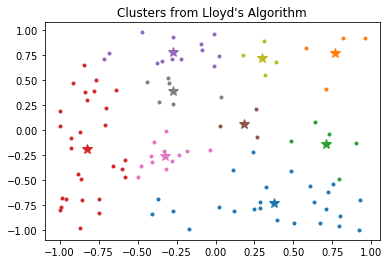

In [155]:
e_in,e_out,clusters = rbf(X,y,test_X,test_y,9,gamma=1.5,plot=True)

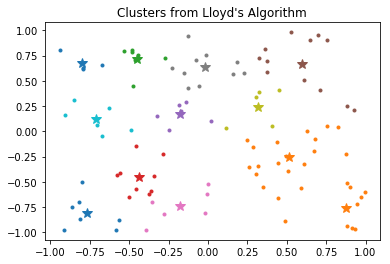

In [106]:
e_in,e_out,clusters = rbf(X,y,test_X,test_y,12,gamma=1.5,plot=True)